In [1]:
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import numpy as np
print("NumPy version: {}".format(np.__version__))
import scipy as sp
print("SciPy version: {}".format(sp.__version__))
import IPython
print("IPython version: {}".format(IPython.__version__))
import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))
import matplotlib.pyplot as plt
# Import seaborn
import seaborn as sns

Python version: 3.8.16 | packaged by conda-forge | (default, Feb  1 2023, 16:05:36) 
[Clang 14.0.6 ]
pandas version: 1.5.3
NumPy version: 1.24.2
SciPy version: 1.10.0
IPython version: 8.9.0
scikit-learn version: 1.2.2


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("Customer Clustering Bisecting Kmeans prueba")\
      .config("spark.some.config.option", "some-value")\
      .getOrCreate()

24/01/11 20:48:12 WARN Utils: Your hostname, MacBook-Pro-de-Rafael.local resolves to a loopback address: 127.0.0.1; using 10.5.61.97 instead (on interface en0)
24/01/11 20:48:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/11 20:48:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/01/11 20:48:14 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/01/11 20:48:14 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/01/11 20:48:14 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [3]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [4]:
customer=pd.read_csv('/Users/rafaelotero/Desktop/Credit Card Customer Data.csv')

In [5]:
#Definimos los percentiles

Q1 = customer["Avg_Credit_Limit"].quantile(0.25)
Q2 = customer["Avg_Credit_Limit"].quantile(0.50)
Q3 = customer["Avg_Credit_Limit"].quantile(0.75)

In [6]:
IQR = Q3-Q1
limite_bajo  = Q1 - 1.5 * IQR
limite_alto = Q3 + 1.5 * IQR

In [7]:
customer['Avg_Credit_Limit'] = np.where((customer['Avg_Credit_Limit'] > limite_alto), limite_alto, customer['Avg_Credit_Limit'])

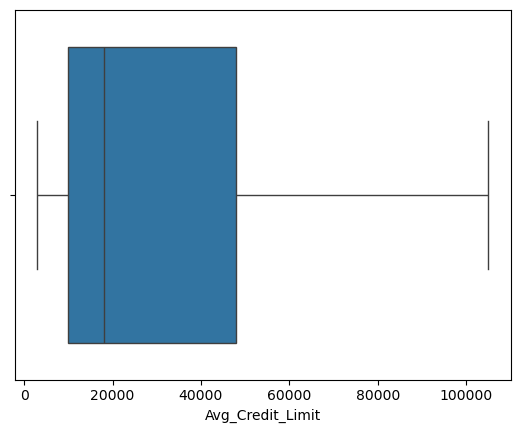

In [8]:
sns.boxplot(x = customer['Avg_Credit_Limit'])
plt.show()

In [9]:
#Definimos los percentiles

Q12 = customer["Total_visits_online"].quantile(0.25)
Q22 = customer["Total_visits_online"].quantile(0.50)
Q32 = customer["Total_visits_online"].quantile(0.75)

IQR2 = Q32-Q12
limite_bajo2  = Q12 - 1.5 * IQR2
limite_alto2 = Q32 + 1.5 * IQR2

In [10]:
customer['Total_visits_online'] = np.where((customer['Total_visits_online'] > limite_alto2), limite_alto2, customer['Total_visits_online'])

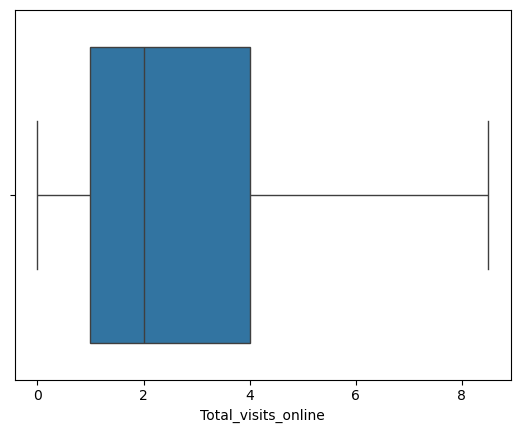

In [11]:
sns.boxplot(x = customer['Total_visits_online'])
plt.show()

In [16]:
#Eliminamos las columnas que no necesitamos

customer_practico = customer.drop(['Sl_No','Customer Key'],axis=1)
customer_practico.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000.0,2,1,1.0,0
1,50000.0,3,0,8.5,9
2,50000.0,7,1,3.0,4
3,30000.0,5,1,1.0,4
4,100000.0,6,0,8.5,3


In [17]:
# Convertir el DataFrame de pandas a DataFrame de Spark
customer_spark = spark.createDataFrame(customer_practico)

# Mostrar el DataFrame de Spark
customer_spark.show()

+----------------+------------------+-----------------+-------------------+----------------+
|Avg_Credit_Limit|Total_Credit_Cards|Total_visits_bank|Total_visits_online|Total_calls_made|
+----------------+------------------+-----------------+-------------------+----------------+
|        100000.0|                 2|                1|                1.0|               0|
|         50000.0|                 3|                0|                8.5|               9|
|         50000.0|                 7|                1|                3.0|               4|
|         30000.0|                 5|                1|                1.0|               4|
|        100000.0|                 6|                0|                8.5|               3|
|         20000.0|                 3|                0|                1.0|               8|
|        100000.0|                 5|                0|                8.5|               2|
|         15000.0|                 3|                0|               

In [18]:
# Para aplicar un modelo de Spark debemos vectorizar nuestros datos para cada punto.

from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=customer_spark.columns,outputCol="features")
customer_spark = assembler.transform(customer_spark)
customer_spark.show()

+----------------+------------------+-----------------+-------------------+----------------+--------------------+
|Avg_Credit_Limit|Total_Credit_Cards|Total_visits_bank|Total_visits_online|Total_calls_made|            features|
+----------------+------------------+-----------------+-------------------+----------------+--------------------+
|        100000.0|                 2|                1|                1.0|               0|[100000.0,2.0,1.0...|
|         50000.0|                 3|                0|                8.5|               9|[50000.0,3.0,0.0,...|
|         50000.0|                 7|                1|                3.0|               4|[50000.0,7.0,1.0,...|
|         30000.0|                 5|                1|                1.0|               4|[30000.0,5.0,1.0,...|
|        100000.0|                 6|                0|                8.5|               3|[100000.0,6.0,0.0...|
|         20000.0|                 3|                0|                1.0|             

In [19]:
# Aplicamos el método StandardScaler para escalar nuestros datos y dejarlos con media nula y varianza la unidad.
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=True)  #Marcamos withMean=True para que nos escale los datos con media nula.

scalerModel = scaler.fit(customer_spark)
customer_spark_scaled = scalerModel.transform(customer_spark)
customer_spark_scaled.show()

+----------------+------------------+-----------------+-------------------+----------------+--------------------+--------------------+
|Avg_Credit_Limit|Total_Credit_Cards|Total_visits_bank|Total_visits_online|Total_calls_made|            features|      scaledFeatures|
+----------------+------------------+-----------------+-------------------+----------------+--------------------+--------------------+
|        100000.0|                 2|                1|                1.0|               0|[100000.0,2.0,1.0...|[2.39712366686785...|
|         50000.0|                 3|                0|                8.5|               9|[50000.0,3.0,0.0,...|[0.64313073989137...|
|         50000.0|                 7|                1|                3.0|               4|[50000.0,7.0,1.0,...|[0.64313073989137...|
|         30000.0|                 5|                1|                1.0|               4|[30000.0,5.0,1.0,...|[-0.0584664308992...|
|        100000.0|                 6|                0|

In [29]:
from pyspark.ml.feature import MinMaxScaler

scalermM = MinMaxScaler(inputCol="features", outputCol="scaledminMaxFeatures")

# Compute summary statistics and generate MinMaxScalerModel
scalermMModel = scalermM.fit(customer_spark_scaled)

# rescale each feature to range [min, max].
customer_spark_scaledmM = scalermMModel.transform(customer_spark_scaled)
customer_spark_scaledmM.show()

+----------------+------------------+-----------------+-------------------+----------------+--------------------+--------------------+--------------------+
|Avg_Credit_Limit|Total_Credit_Cards|Total_visits_bank|Total_visits_online|Total_calls_made|            features|      scaledFeatures|scaledminMaxFeatures|
+----------------+------------------+-----------------+-------------------+----------------+--------------------+--------------------+--------------------+
|        100000.0|                 2|                1|                1.0|               0|[100000.0,2.0,1.0...|[2.39712366686785...|[0.95098039215686...|
|         50000.0|                 3|                0|                8.5|               9|[50000.0,3.0,0.0,...|[0.64313073989137...|[0.46078431372549...|
|         50000.0|                 7|                1|                3.0|               4|[50000.0,7.0,1.0,...|[0.64313073989137...|[0.46078431372549...|
|         30000.0|                 5|                1|         

In [34]:
from pyspark.ml.clustering import BisectingKMeans

# Creamos el modelo Bisecting K-means con el número deseado de clústeres (3 en este caso)
bikmeans = BisectingKMeans(k=3, featuresCol="scaledminMaxFeatures", predictionCol="cluster")

# Ajustamos el modelo a los datos escalados
bikmeansmodel = bikmeans.fit(customer_spark_scaledmM)

# Realizamos la predicción de clústeres en los datos escalados
predictionsbikmeans = bikmeansmodel.transform(customer_spark_scaledmM)

In [35]:
predictionsbikmeans.show()

+----------------+------------------+-----------------+-------------------+----------------+--------------------+--------------------+--------------------+-------+
|Avg_Credit_Limit|Total_Credit_Cards|Total_visits_bank|Total_visits_online|Total_calls_made|            features|      scaledFeatures|scaledminMaxFeatures|cluster|
+----------------+------------------+-----------------+-------------------+----------------+--------------------+--------------------+--------------------+-------+
|        100000.0|                 2|                1|                1.0|               0|[100000.0,2.0,1.0...|[2.39712366686785...|[0.95098039215686...|      2|
|         50000.0|                 3|                0|                8.5|               9|[50000.0,3.0,0.0,...|[0.64313073989137...|[0.46078431372549...|      0|
|         50000.0|                 7|                1|                3.0|               4|[50000.0,7.0,1.0,...|[0.64313073989137...|[0.46078431372549...|      2|
|         30000.

In [37]:
predictionsbikmeans.groupby('cluster').count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1|   50|
|      2|  386|
|      0|  224|
+-------+-----+



In [42]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette score
evaluatorbikmeans = ClusteringEvaluator(featuresCol='scaledminMaxFeatures', predictionCol='cluster')

silhouette = evaluatorbikmeans.evaluate(predictionsbikmeans)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.7325701243817284


In [43]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pcamodel = pca.fit(customer_spark_scaled)
customer_pca_spark = pcamodel.transform(customer_spark_scaled).select('pcaFeatures')

24/01/11 21:29:55 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [44]:
customer_pca_spark.show(truncate=False)

+-----------------------------------------+
|pcaFeatures                              |
+-----------------------------------------+
|[-0.7341660838269763,0.8986051399540523] |
|[2.3787814650682737,2.692662673419947]   |
|[-0.3396694603751786,1.1843807733309495] |
|[0.2827512382120267,0.00948478537336368] |
|[-0.2852265225563084,3.882247740168497]  |
|[1.994334188038595,-0.06798878644311804] |
|[-0.23527258568068543,3.7618948812794506]|
|[0.6432572911233393,-0.2122992437751765] |
|[1.3159050700801926,-0.20163524525189527]|
|[1.7727839938799108,-0.26869904938669065]|
|[1.5878775339906346,1.0222028980506863]  |
|[1.967175572670473,0.09360216563019089]  |
|[2.6301214229794234,0.14104409660744238] |
|[2.3060095853566804,0.3780276922569129]  |
|[1.7583364694395265,-0.1547413551582886] |
|[2.5267144337077,0.7766733893147872]     |
|[1.3270062113365433,-0.30263163594878034]|
|[1.7595829497115316,0.1630024579965316]  |
|[1.7337408008592359,-0.6474402373687582] |
|[1.815596161063436,0.9110151424

In [45]:
column_names=['Primera_componente','Segunda_Componente']
##ESTO ES PARA CONVERTIR EL VECTOR DENSE (DONDE SE HA ALMACENADO LAS COMPONENTES DE SPARK EN UN DATAFRAME)
customer_pca = customer_pca_spark.rdd.map(lambda x:[float(y) for y in x['pcaFeatures']]).toDF(column_names)

In [46]:
customer_pca.show(truncate=False)

+--------------------+--------------------+
|Primera_componente  |Segunda_Componente  |
+--------------------+--------------------+
|-0.7341660838269763 |0.8986051399540523  |
|2.3787814650682737  |2.692662673419947   |
|-0.3396694603751786 |1.1843807733309495  |
|0.2827512382120267  |0.00948478537336368 |
|-0.2852265225563084 |3.882247740168497   |
|1.994334188038595   |-0.06798878644311804|
|-0.23527258568068543|3.7618948812794506  |
|0.6432572911233393  |-0.2122992437751765 |
|1.3159050700801926  |-0.20163524525189527|
|1.7727839938799108  |-0.26869904938669065|
|1.5878775339906346  |1.0222028980506863  |
|1.967175572670473   |0.09360216563019089 |
|2.6301214229794234  |0.14104409660744238 |
|2.3060095853566804  |0.3780276922569129  |
|1.7583364694395265  |-0.1547413551582886 |
|2.5267144337077     |0.7766733893147872  |
|1.3270062113365433  |-0.30263163594878034|
|1.7595829497115316  |0.1630024579965316  |
|1.7337408008592359  |-0.6474402373687582 |
|1.815596161063436   |0.91101514

In [52]:
customer_pca = customer_pca.toPandas()

In [53]:
customer_pca.head()

,Primera_componente,Segunda_Componente
0,-0.734166,0.898605
1,2.378781,2.692663
2,-0.339669,1.184381
3,0.282751,0.009485
4,-0.285227,3.882248


In [50]:
customer_bikmeans.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,features,scaledFeatures,scaledminMaxFeatures,cluster
0,100000.0,2,1,1.0,0,"[100000.0, 2.0, 1.0, 1.0, 0.0]","[2.397123666867853, -1.2482780199737058, -0.85...","[0.9509803921568628, 0.1111111111111111, 0.2, ...",2
1,50000.0,3,0,8.5,9,"[50000.0, 3.0, 0.0, 8.5, 9.0]","[0.643130739891375, -0.7869882701513965, -1.47...","[0.4607843137254902, 0.2222222222222222, 0.0, ...",0
2,50000.0,7,1,3.0,4,"[50000.0, 7.0, 1.0, 3.0, 4.0]","[0.643130739891375, 1.0581707291378408, -0.859...","[0.4607843137254902, 0.6666666666666666, 0.2, ...",2
3,30000.0,5,1,1.0,4,"[30000.0, 5.0, 1.0, 1.0, 4.0]","[-0.0584664308992161, 0.13559122949322222, -0....","[0.2647058823529412, 0.4444444444444444, 0.2, ...",2
4,100000.0,6,0,8.5,3,"[100000.0, 6.0, 0.0, 8.5, 3.0]","[2.397123666867853, 0.5968809793155315, -1.472...","[0.9509803921568628, 0.5555555555555556, 0.0, ...",1


In [54]:
#Añadimos nuestras predicciones de kmeans al dataset customer que teníamos antes
customer_bikmeans = predictionsbikmeans.toPandas()
customer_bikmeans = pd.concat([customer_pca, customer_bikmeans[['cluster']]], axis=1)

In [56]:
customer_bikmeans.head()

,Primera_componente,Segunda_Componente,cluster
0,-0.734166,0.898605,2
1,2.378781,2.692663,0
2,-0.339669,1.184381,2
3,0.282751,0.009485,2
4,-0.285227,3.882248,1


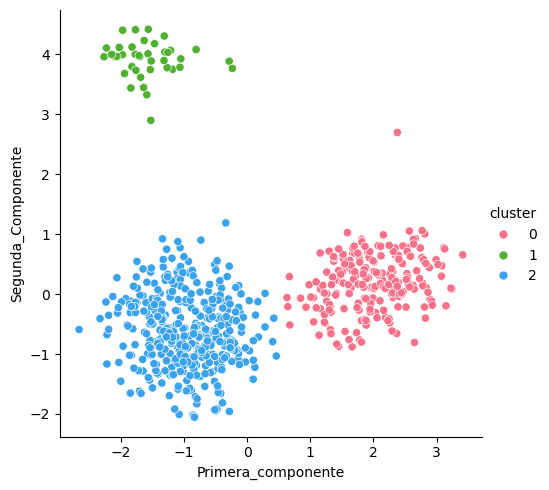

In [57]:
# Definir una paleta de colores para los 3 labels
palette = sns.color_palette("husl", 3)

# Crear el gráfico relacional con colores específicos para cada label
sns.relplot(data=customer_bikmeans, x="Primera_componente", y="Segunda_Componente", hue="cluster", palette=palette)

plt.show()

LA ÚNICA DIFERENCIA CON EL MODELO BISECTING K-MEANS ES QUE ESTE MODELO ES SENSIBLE AL ESCALADO STANDARDSCALER QUE CONVIERTE LOS DATOS A UNA DISTRIBUCIÓN NORMAL. ENTONCES, POR ESA RAZÓN SE HA UTILIZADO OTRO ESCALADO CONOCIDO COMO MINMAXSCALER, QUE TAMBIÉN DA BUEN RESULTADO Y EL COEFICIENTE DE SILUETTE ES NOTABLEMENTE BUENO, AUNQUE LIGERAMENTE MÁS BAJO QUE EL MODELO RENDIDO DE K-MEANS Y GMM.